[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abdul_Razzak_Ghan_2000/fig_4_kinetic_limitations.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Abdul_Razzak_Ghan_2000/fig_4_kinetic_limitations.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abdul_Razzak_Ghan_2000/fig_4_kinetic_limitations.ipynb)

#### based on Figs. 4 from Abdul-Razzak and Ghan 2000 (JGR: Atmos.)  "_A parameterization of aerosol activation: 2. Multiple aerosol types_"

An example of kinetic limitations of growth for large aerosols

https://doi.org/10.1029/1999JD901161

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'omp'  # PySDM and PyMPDATA are incompatible with TBB threads
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [4]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si

from PySDM_examples.Abdul_Razzak_Ghan_2000.run_ARG_parcel import run_parcel
from PySDM_examples.Abdul_Razzak_Ghan_2000 import data_from_ARG2000_paper as ARG_paper

n_sd_per_mode = 20

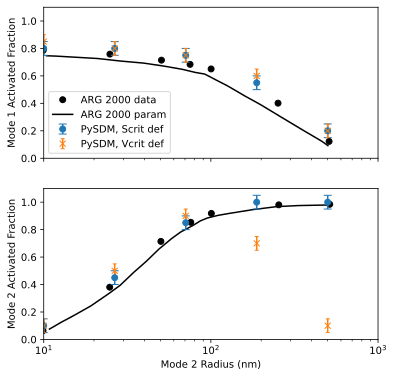

HTML(value="<a href='./fig_4.pdf' target='_blank'>./fig_4.pdf</a><br>")

In [2]:
rad2 = np.geomspace(10,500,5) * si.nm
AF_S = np.zeros((2,len(rad2)))
AF_V = np.zeros((2,len(rad2)))
AFerror = np.zeros(len(rad2))

w = 0.5 * si.m / si.s
N2 = 100 / si.cm**3
sol2 = 1 # 100% ammonium sulfate

for i,rad2i in enumerate(rad2):
    output = run_parcel(w, sol2, N2, rad2i, n_sd_per_mode)
    AF_S[:,i] = output.activated_fraction_S
    AF_V[:,i] = output.activated_fraction_V
    AFerror[i] = output.error[0]

fig, axes = pyplot.subplots(2, 1, sharex=True, figsize=(6,6))
axes[0].plot(np.asarray(ARG_paper.Fig4a_rad2_obs)*1e3, ARG_paper.Fig4a_AF_obs, "ko", label="ARG 2000 data")
axes[0].plot(np.asarray(ARG_paper.Fig4a_rad2_param)*1e3, ARG_paper.Fig4a_AF_param, "k-", label="ARG 2000 param")
axes[1].plot(np.asarray(ARG_paper.Fig4b_rad2_obs)*1e3, ARG_paper.Fig4b_AF_obs, "ko")
axes[1].plot(np.asarray(ARG_paper.Fig4b_rad2_param)*1e3, ARG_paper.Fig4b_AF_param, "k-", label="ARG 2000 param")

for i, ax in enumerate(axes):
    ax.errorbar(rad2 / si.nm, AF_S[i,:], yerr=AFerror, fmt='o', capsize=4, label="PySDM, Scrit def")
    ax.errorbar(rad2 / si.nm, AF_V[i,:], yerr=AFerror, fmt='x', capsize=2, label="PySDM, Vcrit def")
    ax.set_ylabel(f'Mode {i+1} Activated Fraction')
    ax.set_ylim([0,1.1])
    ax.set_xscale('log')
    ax.set_xlim([10,1000])

pyplot.xlabel('Mode 2 Radius (nm)')
axes[0].legend(loc="best")
show_plot("fig_4.pdf")

## Kinetic limitations

Differences in activated fraction as diagnosed from peak supersaturation (compared to critical supersaturations) vs. droplet volumes (compared to critical volumes) is evident in this example for the cases where Mode 2 has a very large mean radius. Here we can see the kinetic limitations of activation where the large droplets take finite time to come into equilibrium with the ambient humidity and grow past their critical sizes. This is explored more in the figures below which show first the profile of ambient humidity compared to the critical supersaturation of each droplet, and then profiles of the ratio of the actual droplet volume to the critical volume. 

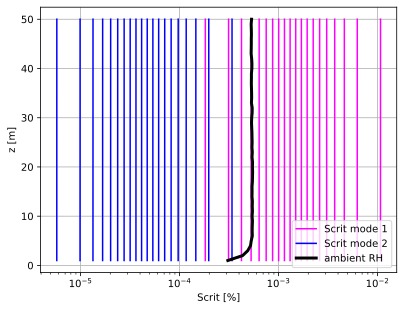

HTML(value="<a href='./RH_profile.pdf' target='_blank'>./RH_profile.pdf</a><br>")

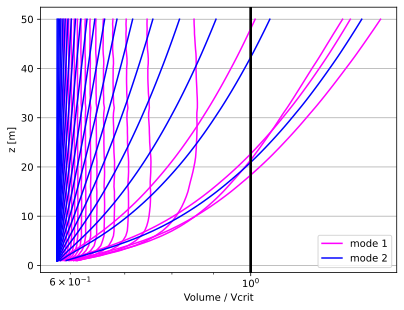

HTML(value="<a href='./Droplet_profile.pdf' target='_blank'>./Droplet_profile.pdf</a><br>")

In [3]:
for drop_id, Scrit in enumerate(output.attributes['critical saturation']):
    if drop_id < n_sd_per_mode:
        pyplot.plot(
            np.asarray(Scrit) - 1,
            output.profile['z'],
            color='magenta',
            label="Scrit mode 1" if drop_id == 0 else ""
        )
    else:
        pyplot.plot(
            np.asarray(Scrit) - 1,
            output.profile['z'],
            color='blue',
            label="Scrit mode 2" if drop_id == n_sd_per_mode else ""
        )
    pyplot.xlabel('Scrit [%]')
    pyplot.ylabel('z [m]')

pyplot.plot(np.asarray(output.profile['RH'])-1, output.profile['z'], 'k', lw=3, label='ambient RH')
pyplot.xscale('log')
pyplot.legend(loc='lower right')
pyplot.grid()
show_plot("RH_profile.pdf")

from PySDM import Formulae
frm = Formulae()
for drop_id, Vcrit in enumerate(output.attributes['critical volume']):
    volume = np.asarray(output.attributes['volume'][drop_id])
    if drop_id < n_sd_per_mode:
        pyplot.plot(
            frm.trivia.radius(volume=volume) / frm.trivia.radius(volume=np.asarray(Vcrit)),
            output.profile['z'],
            color='magenta',
            label="mode 1" if drop_id == 0 else ""
        )
    else:
        pyplot.plot(
            frm.trivia.radius(volume=volume) / frm.trivia.radius(volume=np.asarray(Vcrit)),
            output.profile['z'],
            color='blue',
            label="mode 2" if drop_id == n_sd_per_mode else ""
        )
    pyplot.xlabel('Volume / Vcrit')
    pyplot.ylabel('z [m]')
    pyplot.axvline(1, color='k')

pyplot.xscale('log')
pyplot.legend(loc='lower right')
pyplot.grid()
show_plot("Droplet_profile.pdf")